In [25]:
import os
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing

image_size_full = 256 #256 full in 768

In [26]:
import os
import torch
import numpy as np
import cv2  # OpenCV for image processing
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, images_path, masks_path, patch_size=256, augment=True):
        self.images_path = images_path
        self.masks_path = masks_path

        valid_image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')
        self.image_files = sorted([f for f in os.listdir(images_path) if not f.startswith('.') and f.lower().endswith(valid_image_extensions)])
        self.mask_files = sorted([f for f in os.listdir(masks_path) if not f.startswith('.') and f.lower().endswith(valid_image_extensions)])

        self.patch_size = patch_size
        self.augment = augment

        # Augmentation
        self.augmentations = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=15, p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.GaussianBlur(blur_limit=3, p=0.2),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
                A.CLAHE(clip_limit=2, p=0.3),
            ],
            additional_targets={"mask": "image"},
        )

    def __len__(self):
        # Num of patches = num_images * (num_patch_row * num_patch_col)
        num_patches_per_image = (2048 // self.patch_size) ** 2
        return len(self.image_files) * num_patches_per_image

    def __getitem__(self, idx):
        # Determine image and corresponding patch
        image_idx = idx // ((2048 // self.patch_size) ** 2)  # image index
        patch_idx = idx % ((2048 // self.patch_size) ** 2)  # index of patch in the grid

        # Load image and mask
        image_path = os.path.join(self.images_path, self.image_files[image_idx])
        
        mask_path = os.path.join(self.masks_path, self.mask_files[image_idx])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8) / 255

        # Evaluate position of the patch
        row = patch_idx // (2048 // self.patch_size)
        col = patch_idx % (2048 // self.patch_size)
        y_start = row * self.patch_size
        x_start = col * self.patch_size
        y_end = y_start + self.patch_size
        x_end = x_start + self.patch_size

        # Extract patch
        image_patch = image[y_start:y_end, x_start:x_end]
        mask_patch = mask[y_start:y_end, x_start:x_end]

        # Apply augmentation
        if self.augment:
            augmented = self.augmentations(image=image_patch, mask=mask_patch)
            image_patch, mask_patch = augmented["image"], augmented["mask"]

        coords_intensities = self.generate_coords_intensities(image_patch)

        return coords_intensities, torch.tensor(mask_patch.flatten(), dtype=torch.long)

    def generate_coords_intensities(self, image_patch, device='mps'):
        """
        Generate normalized coordinate and intensity of the patch.
        Args:
            image_patch (numpy.ndarray o torch.Tensor): Patch with dim (H, W) or (C, H, W).
            device (torch.device, opzionale): mps
        Returns:
            torch.Tensor: Tensor with coordinates and intensity with size (H*W, 3).
        """
        if isinstance(image_patch, torch.Tensor):
            image_patch = image_patch.cpu().numpy()

        # Check input format
        if len(image_patch.shape) == 3:  # (C, H, W)
            if image_patch.shape[0] == 1:  # (1, H, W)
                image_patch = image_patch.squeeze(0)  # Remove channel
            elif image_patch.shape[0] == 3:  # Case RGB (3, H, W)
                image_patch = np.mean(image_patch, axis=0)  # Grey convertion

        if len(image_patch.shape) != 2:
            raise ValueError(f"Expected image_patch to have 2 dimensions (H, W), but got {image_patch.shape}")

        # Extract H and W
        H, W = image_patch.shape

        y_coords, x_coords = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
        coords = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2).astype(np.float32)
        coords /= np.array([W - 1, H - 1], dtype=np.float32)

        # Extract coordinate
        intensities = image_patch.flatten().reshape(-1, 1)
        coords_intensities = np.concatenate([coords, intensities], axis=-1)

        # Tensor torch conversion
        tensor = torch.tensor(coords_intensities, dtype=torch.float32)

        # Move on mps
        if device is not None:
            tensor = tensor.to(device)

        return tensor



In [27]:
from torch.utils.data import DataLoader

images_path = '/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original' #'path/to/images'
masks_path = '/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Ground truth' #'path/to/masks'
# Create dataset and dataloader
batch_size = 128  

dataset = SegmentationDataset(images_path, masks_path, patch_size=image_size_full, augment=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

coords_intensities, sampled_labels = next(iter(dataloader))
print(coords_intensities.shape, sampled_labels.shape)

torch.Size([128, 65536, 3]) torch.Size([128, 65536])


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs):
        super(PositionalEncoding, self).__init__()
        self.num_freqs = num_freqs

    def forward(self, x):
        frequencies = torch.linspace(0, self.num_freqs - 1, self.num_freqs, device=x.device)
        frequencies = 2.0 ** frequencies  # Forma: (num_freqs,)
        frequencies = frequencies.view(1, 1, -1)  # Forma: (1, 1, num_freqs)

        x = x.unsqueeze(-1)  # Forma: (N, num_coords, 1)
        x = x * frequencies  # Broadcasting, forma: (N, num_coords, num_freqs)
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)  # (N, num_coords, num_freqs * 2)
        x = x.view(x.shape[0], -1)  # flat in (N, num_coords * num_freqs * 2)
        return x


class AdaptiveDropout(nn.Module):
    def __init__(self, initial_p=0.5, decay_factor=0.95):
        super(AdaptiveDropout, self).__init__()
        self.p = initial_p
        self.decay_factor = decay_factor

    def forward(self, x):
        if self.training:
            return F.dropout(x, p=self.p, training=True)
        else:
            return x

    def step(self):
        self.p *= self.decay_factor  # Decrease dropout probability


import torch.nn.functional as F

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=1.0):
        super(SineLayer, self).__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features

        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                self.linear.weight.uniform_(
                    -np.sqrt(6 / self.in_features) / self.omega_0,
                    np.sqrt(6 / self.in_features) / self.omega_0,
                )

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(self.omega_0 * x)
        return x


import torch
import torch.nn as nn
import torch.nn.functional as F

class INRSegmentationModel(nn.Module):
    def __init__(self, num_classes=2, hidden_dim=256, num_layers=5, num_freqs=10, initial_dropout_p=0.5, outermost_linear=False, linear_network=False):
        super(INRSegmentationModel, self).__init__()
        self.num_classes = num_classes
        self.pos_enc = PositionalEncoding(num_freqs)

        num_coords = 2  #  (x, y)
        input_dim = num_coords * num_freqs * 2 + 1  # +1 for intensity

        self.linear_network = linear_network
        self.outermost_linear = outermost_linear

        self.reduction_layer = nn.Linear(input_dim, hidden_dim)

        # Adaptive dropout to reduce overfitting
        self.dropouts = nn.ModuleList([AdaptiveDropout(initial_dropout_p) for _ in range(num_layers - 1)])

        # Multi-Layer Perceptron (MLP)
        self.mlp = nn.ModuleList()

        # First layer
        self.mlp.append(
            nn.Sequential(
                SineLayer(in_features=hidden_dim, out_features=hidden_dim, is_first=True),
                nn.BatchNorm1d(hidden_dim),  # Stabilize training
            )
        )

        for _ in range(1, num_layers - 2):
            if linear_network:
                self.mlp.append(
                    nn.Sequential(
                        nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                        nn.ReLU(),
                        nn.BatchNorm1d(hidden_dim),
                    )
                )
            else:
                self.mlp.append(
                    nn.Sequential(
                        SineLayer(in_features=hidden_dim, out_features=hidden_dim),
                        nn.BatchNorm1d(hidden_dim),
                    )
                )

        # Final layer
        if outermost_linear:
            self.mlp.append(nn.Linear(hidden_dim, 1))
        else:
            self.mlp.append(nn.SineLayer(in_features=hidden_dim, out_features=1, is_first=false)) 


    def forward(self, coords_intensities):
        coords = coords_intensities[:, :-1]  # Shape: (N, num_coords)
        intensities = coords_intensities[:, -1].unsqueeze(-1)  # Shape: (N, 1)

        x = self.pos_enc(coords)  # Shape: (N, encoded_features)

        x = torch.cat([x, intensities], dim=-1) 

        x = self.reduction_layer(x)  # Shape: (N, hidden_dim)

        for i, layer in enumerate(self.mlp[:-1]):
            x = layer(x)
            if x is None:
                raise ValueError(f"Layer {i} returned None")
            x = self.dropouts[i](x)

        x = self.mlp[-1](x)

        # Last activation
        if self.outermost_linear:
            x = F.softmax(x, dim=-1)
        else:
            x = torch.sigmoid(x)

        return x


device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")


Using device: mps


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2, smooth=1):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        Inputs: probability of model predictions 
        Targets: mask (val 0 or 1)
        """
        inputs = torch.clamp(inputs, 1e-7, 1 - 1e-7)

        # Focal Loss
        focal_loss = -self.alpha * (1 - inputs) ** self.gamma * targets * torch.log(inputs) - \
                     (1 - self.alpha) * inputs ** self.gamma * (1 - targets) * torch.log(1 - inputs)
        focal_loss = focal_loss.mean()

        # CDice Loss
        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (union + self.smooth)

        # Combine loss
        total_loss = focal_loss + dice_loss

        return total_loss

In [30]:
# Parameters
num_classes = 2  # Binary classification
num_layers = 4
hidden_dim = image_size_full  # use dim of image
outer_layer_linear = False
num_freq = 5
linear_network = False
alpha = 0.75
gamma = 2
smooth = 1e-5

In [31]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
import torch.optim as optim
import torch
import torch.nn as nn

model = INRSegmentationModel(
    num_classes=num_classes,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    outermost_linear=outer_layer_linear,
    num_freqs=num_freq,
    linear_network=linear_network,
).to(device)

# model.load_state_dict(torch.load('retina_segmentation_model_new_dataset_1_layer4_alpha075_gamma2.pth'))

optimizer = optim.Adam(model.parameters(), lr=1e-1)

criterion = FocalDiceLoss(alpha=alpha, gamma=gamma, smooth=smooth).to(device)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=1e-6)

num_epochs = 50
losses = []

best_loss = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for coords_intensities, labels in dataloader:
        coords_intensities, labels = coords_intensities.to(device), labels.to(device)
        optimizer.zero_grad()

        coords_intensities = coords_intensities.view(-1, 3)
        labels = labels.view(-1)
        # Forward pass
        outputs = model(coords_intensities)

        # Reshape degli output and target
        outputs = outputs.squeeze(-1)  

        # Loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss per epoch
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)

    # Update learning rate with scheduler 
    scheduler.step(epoch_loss)

    # Save model
    if epoch == 0 or (epoch + 1) % 1 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, LR: {current_lr}')
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'loss': epoch_loss,
        # }, f'model_checkpoint_epoch_{epoch + 1}.pth')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'retina_segmentation_model_new_dataset_1_layer4_alpha075_gamma2.pth')
        print('Model saved!!!!')


/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_2092/834444385.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('retina_segme

Epoch [1/50], Loss: 0.9231, LR: 0.1
Epoch [2/50], Loss: 0.9118, LR: 0.1
Epoch [3/50], Loss: 0.9118, LR: 0.1
Epoch [4/50], Loss: 0.9118, LR: 0.1
Epoch [5/50], Loss: 0.9118, LR: 0.1
Epoch [6/50], Loss: 0.9119, LR: 0.1
Epoch [7/50], Loss: 0.9119, LR: 0.1
Epoch [8/50], Loss: 0.9119, LR: 0.03
Epoch [9/50], Loss: 0.9119, LR: 0.03
Epoch [10/50], Loss: 0.9118, LR: 0.03
Epoch [11/50], Loss: 0.9118, LR: 0.03
Epoch [12/50], Loss: 0.9118, LR: 0.03
Epoch [13/50], Loss: 0.9118, LR: 0.03
Epoch [14/50], Loss: 0.9118, LR: 0.009
Epoch [15/50], Loss: 0.9118, LR: 0.009
Epoch [16/50], Loss: 0.9118, LR: 0.009
Epoch [17/50], Loss: 0.9118, LR: 0.009
Epoch [18/50], Loss: 0.9118, LR: 0.009
Epoch [19/50], Loss: 0.9118, LR: 0.009
Epoch [20/50], Loss: 0.9118, LR: 0.0026999999999999997
Epoch [21/50], Loss: 0.9118, LR: 0.0026999999999999997
Epoch [22/50], Loss: 0.9118, LR: 0.0026999999999999997
Epoch [23/50], Loss: 0.9115, LR: 0.0026999999999999997
Epoch [24/50], Loss: 0.9118, LR: 0.0026999999999999997
Epoch [25/50]

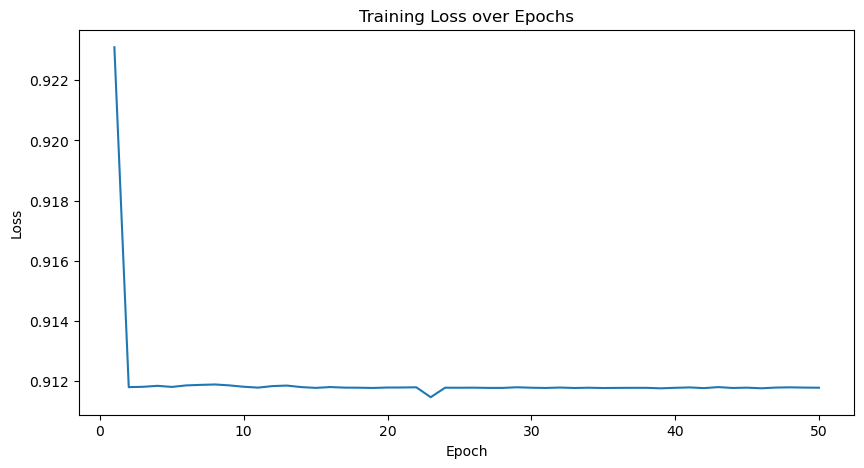

In [32]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [33]:
name_of_model = 'retina_segmentation_model_new_dataset_1_layer4_alpha075_gamma2.pth'

In [34]:
torch.save(model.state_dict(), name_of_model)

In [35]:
# Evaluation
test_image_path = "/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original/1_A.png"
test_mask_path = "/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Ground truth/1_A.png"

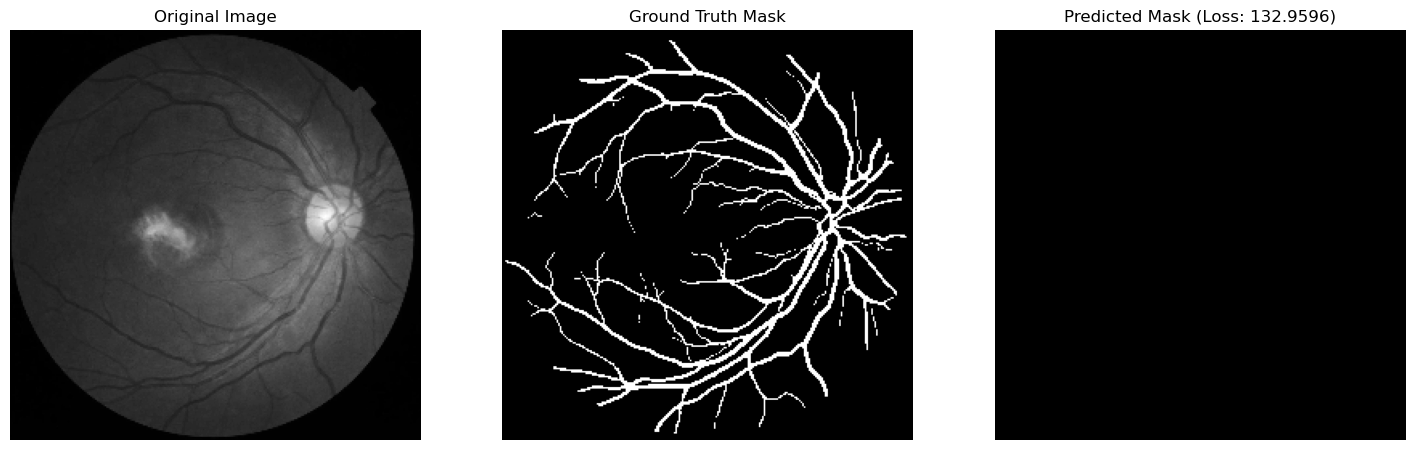

In [36]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def split_into_patches(image, patch_size):
    """
    Divide image in patches of input dim
    """
    _, H, W = image.shape  
    patches = []
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch = image[:, i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    return patches

# Reconstruct image
def reconstruct_from_patches(patches, image_shape, patch_size):
    """
    Reconstruct the image
    """
    H, W = image_shape  
    reconstructed_image = torch.zeros((H, W), device=patches[0].device)  
    count_map = torch.zeros((H, W), device=patches[0].device)  

    patch_index = 0
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            h_patch, w_patch = patches[patch_index].shape[1:]
            reconstructed_image[i:i + h_patch, j:j + w_patch] += patches[patch_index][0].to(reconstructed_image.device)
            count_map[i:i + h_patch, j:j + w_patch] += 1
            patch_index += 1

    # Avoid zero division
    count_map = torch.clamp(count_map, min=1)
    reconstructed_image /= count_map

    return reconstructed_image



def evaluate_model(model, dataset, image, mask, patch_size, criterion):
    model.eval()

    # pre-processing
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    mask_tensor = torch.tensor(mask, dtype=torch.long).to(device)

    image_tensor = image_tensor.squeeze(0)

    # Split into patches
    patches_image = split_into_patches(image_tensor, patch_size)

    predicted_patches = []
    losses = []

    for img_patch in patches_image:
        H, W = img_patch.shape[1:]
        coords_intensities = dataset.generate_coords_intensities(img_patch, device=device)

        with torch.no_grad():
            outputs = model(coords_intensities)  # output per pixel
            outputs = outputs.squeeze(-1).view(H, W)  # Shape into 2D

            # Predizioni binarie
            predicted_labels = (outputs > 0.5).long()
            predicted_patches.append(predicted_labels.unsqueeze(0))

            targets = img_patch.reshape(-1)

            loss = criterion(outputs.view(-1), targets)
            losses.append(loss.item())


    predicted_mask = reconstruct_from_patches(predicted_patches, image_tensor.shape[1:], patch_size).cpu().numpy()


    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Calcola la perdita totale
    total_loss = sum(losses)

    # Visualizza i risultati
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted Mask (Loss: {total_loss:.4f})")

    plt.show()


Evaluation
# Load image and mask 
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (256, 256), interpolation=cv2.INTER_LINEAR)

test_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.resize(test_mask, (256, 256), interpolation=cv2.INTER_NEAREST)

evaluate_model(model, dataset, test_image, test_mask, patch_size=64, criterion=criterion)


In [38]:
# some results

# layers 4, alpha 0.75, gamma 2, mooth 1e-5 --> loss 0.8846 (50 epochs)
# layers 6, alpha 0.75, gamma 2, mooth 1e-5 --> loss 0.9217 (9 epochs)
# layers 2, alpha 0.75, gamma 2, mooth 1e-5 --> loss 0.8762 (9 epochs)